In [97]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

#Read in the dataset
lq=pd.read_excel('../Datasets/combined_results_w_pop.xlsx','Large System Financial Qs')
sq=pd.read_excel('../Datasets/combined_results_w_pop.xlsx','Small System Financial Qs')
conn_ref=pd.read_excel('../Datasets/combined_results_w_pop.xlsx','Population and Connections')
conn_ref.loc[:,'Bin']=pd.cut(conn_ref['Service Connections'],bins=[0,1045,3383,6458,10000,1000000000],
                            labels=['A','B','C','D','Large'])

In [265]:
#Question 1: How many systems will require financial assistance?
dat=sq[['PWSID','sys_name','months_before_assist','Population','Service Connections']].dropna(subset=['months_before_assist'])
def need_assist(row):
    n=['A','B']
    if(row['months_before_assist'] in n):
        return('Y')
    else:
        return('N')
    
dat.loc[:,'Financial crisis']=dat.apply(need_assist,axis=1)
q1_store=pd.DataFrame()
for i,r in dat.iterrows():
    p=r['PWSID']
    res=r['months_before_assist']
    if len(p)>9:
        results=p.split(',')
        res2=[x.strip() for x in results]
        #look up the number of connections
        conns=conn_ref[conn_ref['PWSID'].isin(res2)]
    else:
        conns=conn_ref[conn_ref['PWSID']==p]
    conns.loc[:,'resp']=res
    q1_store=q1_store.append(conns,ignore_index=True)

q1_store=q1_store.drop_duplicates()
qg=q1_store.groupby(['resp','Bin']).size().unstack().iloc[:,:-1]
qg2=qg.copy()
ntot=qg2.sum(axis=1)
for c in qg2.columns:
    qg2.loc[:,c]=qg2[c]/ntot

C:\Anaconda-3.7\lib\site-packages\pandas\core\indexing.py:845: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = _infer_fill_value(value)
C:\Anaconda-3.7\lib\site-packages\pandas\core\indexing.py:966: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s


Text(0, 0.5, '% of systems')

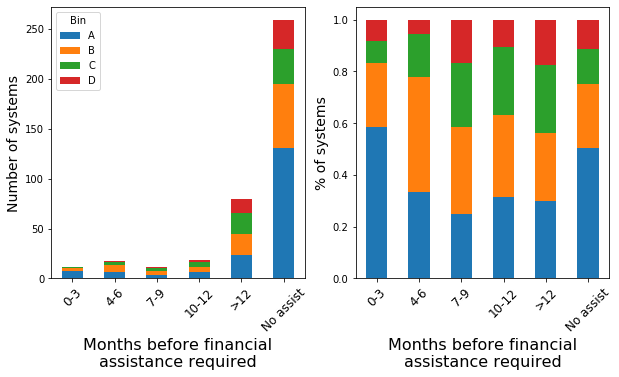

In [266]:
labs=['A','B','C','D','E','F']
labs2=['0-3','4-6','7-9','10-12','>12','No assist']
fig,ax=plt.subplots(1,2,figsize=(10,5))
qg.plot(kind='bar',ax=ax[0],stacked=True)
ax[0].set_xticklabels(labs2,rotation=45,size=12)        
ax[0].set_xlabel('Months before financial\nassistance required',size=16)
ax[0].set_ylabel('Number of systems',size=14)

qg2.plot(kind='bar',ax=ax[1],stacked=True,legend=None)
ax[1].set_xticklabels(labs2,rotation=45,size=12)        
ax[1].set_xlabel('Months before financial\nassistance required',size=16)
ax[1].set_ylabel('% of systems',size=14)

In [267]:
#Question 2: How many systems have deficits equivalent to x% of reserve funds?
dat=sq[['PWSID','sys_name','expense_2020_Total','revenue_2020_Total','cash_reserve_restricted','cash_reserve_unrestricted','cash_reserve_total','Population','Service Connections']]
dat.loc[:,'budget_diff']=dat['revenue_2020_Total']-dat['expense_2020_Total']
q2_store=pd.DataFrame()
for i,r in dat.iterrows():
    p=r['PWSID']
    res=r['budget_diff']
    cash=r['cash_reserve_total']
    cash_u=r['cash_reserve_unrestricted']
    if (np.isnan(cash_u)&(np.isnan(r['cash_reserve_restricted']))):
        cash_u=cash
    if len(p)>9:
        results=p.split(',')
        res2=[x.strip() for x in results]
        #look up the number of connections
        conns=conn_ref[conn_ref['PWSID'].isin(res2)]
    else:
        conns=conn_ref[conn_ref['PWSID']==p]
    conns.loc[:,'resp']=res
    conns.loc[:,'cash']=cash
    conns.loc[:,'cash_u']=cash_u
    q2_store=q2_store.append(conns,ignore_index=True)
q2_store=q2_store.drop_duplicates()
q22=q2_store.dropna(subset=['resp'])
q2def=q22[(q22['resp']<0)&(q22['cash']>0)].dropna(subset=['cash'])
q2def.loc[:,'cash_u']=q2def['cash_u']+1
q2def.loc[:,'ratio']=q2def['resp']/q2def['cash']
q2def.loc[:,'ratio_u']=q2def['resp']/q2def['cash_u']
ratio_labels=['Over 100% of reserve','75-100% of reserve','50-75% of reserve','25-50% of reserve','Less than 25% of reserve']

q2def.loc[:,'cash label']=pd.cut(q2def['ratio'],bins=[-100,-1,-0.75,-0.5,-0.25,0],
                               labels=ratio_labels)
q2def.loc[:,'cash_u label']=pd.cut(q2def['ratio_u'],bins=[-100,-1,-0.75,-0.5,-0.25,0],
                               labels=ratio_labels)
r2=ratio_labels[::-1]
qg=q2def.groupby(['cash label','Bin']).size().unstack().iloc[:,:-1].reindex(r2)
qg2=qg.copy()
ntot=qg2.sum(axis=1)
for c in qg2.columns:
    qg2.loc[:,c]=qg2[c]/ntot

In [268]:
qg3=q2def.groupby(['cash_u label','Bin']).size().unstack().iloc[:,:-1].reindex(r2)
print(qg)
print(qg3)

Bin                        A   B   C  D
cash label                             
Less than 25% of reserve  27  19  11  8
25-50% of reserve          4   2   2  0
50-75% of reserve          2   0   0  0
75-100% of reserve         2   0   1  1
Over 100% of reserve       4   2   4  0
Bin                        A   B   C  D
cash_u label                           
Less than 25% of reserve  24  17  11  6
25-50% of reserve          4   3   2  2
50-75% of reserve          2   1   0  0
75-100% of reserve         2   0   1  0
Over 100% of reserve       4   1   3  0


Text(0, 0.5, '% of systems')

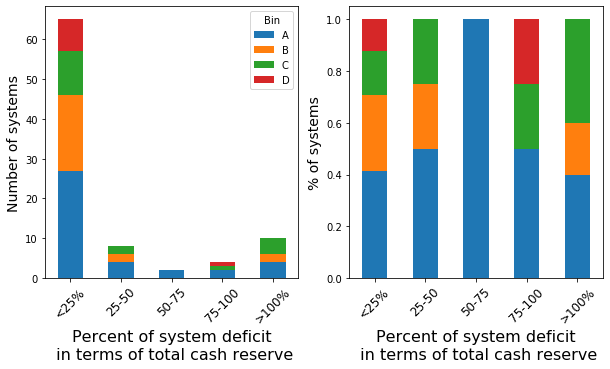

In [269]:
labs=['<25%','25-50','50-75','75-100','>100%']
fig,ax=plt.subplots(1,2,figsize=(10,5))
qg.plot(kind='bar',ax=ax[0],stacked=True)
ax[0].set_xticklabels(labs,rotation=45,size=12)        
ax[0].set_xlabel('Percent of system deficit\n in terms of total cash reserve',size=16)
ax[0].set_ylabel('Number of systems',size=14)

qg2.plot(kind='bar',ax=ax[1],stacked=True,legend=None)
ax[1].set_xticklabels(labs,rotation=45,size=12)        
ax[1].set_xlabel('Percent of system deficit\n in terms of total cash reserve',size=16)
ax[1].set_ylabel('% of systems',size=14)

In [285]:
#Question 5: What is the population served by systems with various levels of financial vulnerability?
#Days of cash on hand? Operating Ratio? Per capita revenue?

#number of days: April through October
ndays=30+31+30+31+31+30+31
dat=sq[['PWSID','sys_name','months_before_assist','expense_2020_Total','revenue_2020_Total','cash_reserve_restricted','cash_reserve_unrestricted','cash_reserve_total','Population','Service Connections']]

q5_store=pd.DataFrame()
for i,r in dat.iterrows():
    p=r['PWSID']
    cash=r['cash_reserve_total']
    cash_u=r['cash_reserve_unrestricted']
    expense=r['expense_2020_Total']
    rev=r['revenue_2020_Total']
    res=r['months_before_assist']
    
    if (np.isnan(cash_u)&(np.isnan(r['cash_reserve_restricted']))):
        #print(cash,r['cash_reserve_restricted'],cash_u)
        cash_u=cash
        #print(cash_u)

    if len(p)>9:
        results=p.split(',')
        res2=[x.strip() for x in results]
        #look up the number of connections
        conns=conn_ref[conn_ref['PWSID'].isin(res2)]
    else:
        conns=conn_ref[conn_ref['PWSID']==p]

    conns.loc[:,'cash']=cash
    conns.loc[:,'cash_u']=cash_u
    conns.loc[:,'cash_u_days']=cash_u/(expense/ndays)
    conns.loc[:,'cash_days']=cash/(expense/ndays)
    conns.loc[:,'op_ratio']=rev/expense
    conns.loc[:,'months']=res
    q5_store=q5_store.append(conns,ignore_index=True)
q5_store=q5_store.drop_duplicates()





C:\Anaconda-3.7\lib\site-packages\pandas\core\indexing.py:845: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = _infer_fill_value(value)
C:\Anaconda-3.7\lib\site-packages\pandas\core\indexing.py:966: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s


In [324]:
#Assign risk scores based on various factors
#5: Extreme
#4: High
#3: Medium-high
#2: Medium
#1: low
#0: None
month_risk={'A':5,'B':4,'C':3,'D':2,'E':1,'F':0}
#only work with the ones that provide all info
q5_data=q5_store
q5_data.loc[:,'cash_score']=pd.cut(q5_data['cash_u_days'],bins=[-1,30,60,90,180,365,1000000000],labels=[5,4,3,2,1,0])
q5_data.loc[:,'ratio_score']=pd.cut(q5_data['op_ratio'],bins=[0,0.5,0.95,1.2,1.5,2,100],labels=[5,4,3,2,1,0])
q5_data.loc[:,'month_score']=q5_data['months'].map(month_risk)
q5_data.loc[:,'score_avg']=q5_data[['ratio_score','cash_score','month_score']].mean(axis=1)
#q5_data['score_avg'].hist()
q5_data.loc[:,'Risk label']=pd.cut(q5_data['score_avg'],bins=[-1,0.25,1.5,2.5,3.5,4.5,5.5],labels=['very low','low','medium','medium high','high','extreme'])

Text(0, 0.5, 'Number of systems')

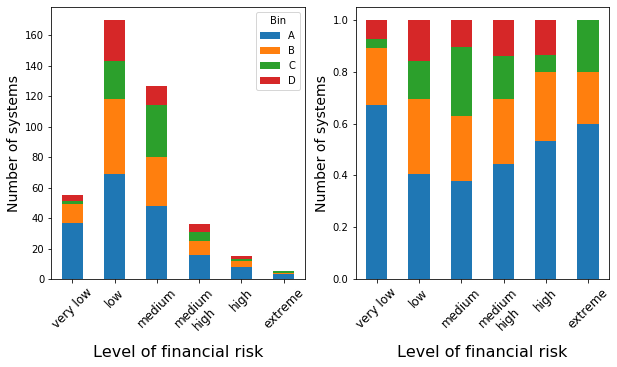

In [348]:
#q5_data.dropna(subset=['score_avg']).to_excel('risk_scores.xlsx',index=False)
q5_plot=q5_data.dropna(subset=['score_avg']).groupby(['Risk label','Bin']).size().unstack().iloc[:,:-1]
qtot=q5_plot.sum(axis=1)
q5_norm=q5_plot.copy()
for c in q5_norm.columns:
    q5_norm.loc[:,c]=q5_norm[c]/qtot

fig,ax=plt.subplots(1,2,figsize=(10,5))
q5_plot.plot(kind='bar',ax=ax[0],stacked=True)
ax[0].set_xticklabels(['very low','low','medium','medium\nhigh','high','extreme'],rotation=45,size=12)        
ax[0].set_xlabel('Level of financial risk',size=16)
ax[0].set_ylabel('Number of systems',size=14)

q5_norm.plot(kind='bar',ax=ax[1],stacked=True,legend=None)
ax[1].set_xticklabels(['very low','low','medium','medium\nhigh','high','extreme'],rotation=45,size=12)        
ax[1].set_xlabel('Level of financial risk',size=16)
ax[1].set_ylabel('Number of systems',size=14)

In [344]:
q5_norm

Bin,A,B,C,D
Risk label,,,,
very low,0.672727,0.218182,0.036364,0.072727
low,0.405882,0.288235,0.147059,0.158824
medium,0.377953,0.251969,0.267717,0.102362
medium high,0.444444,0.250000,0.166667,0.138889
high,0.533333,0.266667,0.066667,0.133333
extreme,0.600000,0.200000,0.200000,0.000000
